## **Introduction to graph ML : predict nodes inside graph network**

In [ ]:
from neo4j import GraphDatabase
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define connection details
URI = "bolt://localhost:7687"
AUTH = ("neo4j", "password")

# Initialize Driver
driver = GraphDatabase.driver(URI, auth=AUTH)

# Define the helper function to return Pandas DataFrames directly
def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [41]:
# 1. Create a constraint to ensure Stream IDs are unique and indexing is fast
run_query("CREATE CONSTRAINT IF NOT EXISTS FOR (s:Stream) REQUIRE s.id IS UNIQUE")

# 2. Load the Streamer data
query_load_nodes = """
LOAD CSV WITH HEADERS FROM 'https://bit.ly/3JjgKgZ' AS row
MERGE (s:Stream {id: row.id})
SET s.language = row.language
"""
run_query(query_load_nodes)

# Check the data
run_query("MATCH (s:Stream) RETURN s.id, s.language LIMIT 5")

,s.id,s.language
0,129004176,en
1,26490481,en
2,213749122,en
3,30104304,en
4,160504245,en


fdfsdg

In [42]:
query_load_edges = """
LOAD CSV WITH HEADERS FROM 'https://bit.ly/3S9Uyd8' AS row
MATCH (s1:Stream {id: row.source})
MATCH (s2:Stream {id: row.target})
MERGE (s1)-[r:SHARED_AUDIENCE]->(s2)
SET r.weight = toInteger(row.weight)
RETURN count(r) as relationships_created
"""

result = run_query(query_load_edges)
print(result)

   relationships_created
0                 131427


In [43]:
# 1. Drop graph if it exists (allows re-running the cell without error)
run_query("CALL gds.graph.drop('twitch', false)")

# 2. Create the projection
# Note: We use UNDIRECTED because if Stream A shares viewers with Stream B, 
# Stream B shares them with Stream A.
query_project = """
CALL gds.graph.project(
    'twitch',
    'Stream',
    {
        SHARED_AUDIENCE: {
            orientation: 'UNDIRECTED',
            properties: 'weight'
        }
    }
)
YIELD graphName, nodeCount, relationshipCount
"""

project_stats = run_query(query_project)
print(project_stats)

Received notification from DBMS server: <GqlStatusObject gql_status='01N00', status_description='warn: feature deprecated. `schema` returned by the procedure `gds.graph.drop` is deprecated.', position=<SummaryInputPosition line=1, column=1, offset=0>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 0, 'line': 1, 'column': 1}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: "CALL gds.graph.drop('twitch', false)"


  graphName  nodeCount  relationshipCount
0    twitch       3721             262854


In [44]:
query_node2vec = """
CALL gds.node2vec.write('twitch', {
    embeddingDimension: 128,
    walkLength: 40,
    iterations: 5,
    inOutFactor: 1.0,
    returnFactor: 1.0,
    writeProperty: 'embedding'
})
YIELD nodeCount, nodePropertiesWritten, computeMillis
"""

n2v_stats = run_query(query_node2vec)
print(n2v_stats)

   nodeCount  nodePropertiesWritten  computeMillis
0       3721                   3721          19146


In [45]:
# Fetch data for analysis
# We calculate degree, weight, and similarity metrics for every edge
analysis_query = """
MATCH (s1:Stream)-[r:SHARED_AUDIENCE]-(s2)
WHERE s1.embedding IS NOT NULL AND s2.embedding IS NOT NULL AND id(s1) < id(s2)
WITH s1, s2, r,
     gds.similarity.cosine(s1.embedding, s2.embedding) AS cosine,
     gds.similarity.euclideanDistance(s1.embedding, s2.embedding) AS euclidean
RETURN 
    cosine,
    euclidean,
    (count{(s1)--()} + count{(s2)--()}) / 2.0 AS avgDegree,
    r.weight AS weight
"""

df_analysis = run_query(analysis_query)
print(f"Loaded {len(df_analysis)} relationships for analysis.")
df_analysis.head()

Received notification from DBMS server: <GqlStatusObject gql_status='01N01', status_description='warn: feature deprecated with replacement. id is deprecated. It is replaced by elementId or consider using an application-generated id.', position=<SummaryInputPosition line=3, column=65, offset=108>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 108, 'line': 3, 'column': 65}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: '\nMATCH (s1:Stream)-[r:SHARED_AUDIENCE]-(s2)\nWHERE s1.embedding IS NOT NULL AND s2.embedding IS NOT NULL AND id(s1) < id(s2)\nWITH s1, s2, r,\n     gds.similarity.cosine(s1.embedding, s2.embedding) AS cosine,\n     gds.similarity.euclideanDistance(s1.embedding, s2.embedding) AS euclidean\nRETURN \n    cosine,\

Loaded 131427 relationships for analysis.


,cosine,euclidean,avgDegree,weight
0,0.208722,3.645549,629.5,72
1,0.302413,3.512741,496.0,27
2,0.236604,3.659144,525.5,71
3,0.405650,3.525569,437.5,47
4,0.352322,3.446644,425.0,12


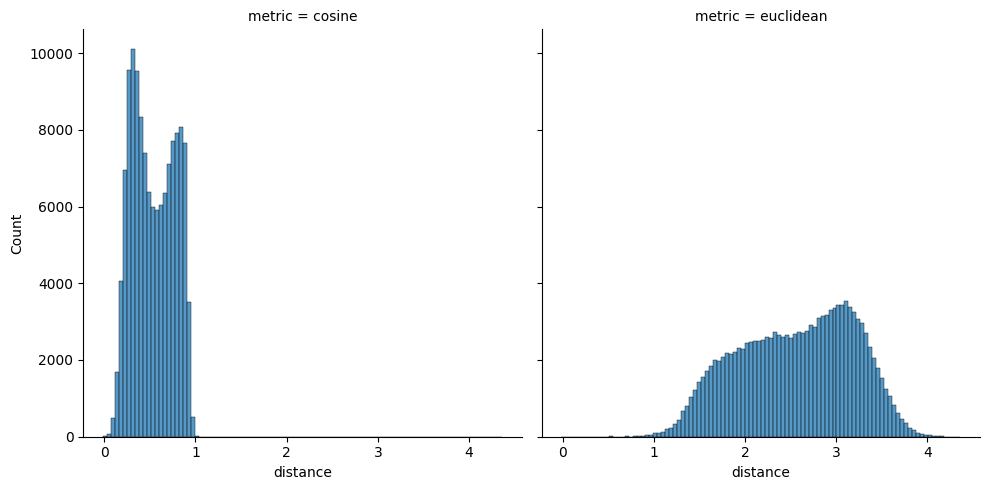

In [46]:
# Prepare data for seaborn (Melt into 'long' format)
df_melted = df_analysis.melt(
    value_vars=['cosine', 'euclidean'], 
    var_name='metric', 
    value_name='distance'
)

# Plot
plt.rcParams["figure.figsize"] = [16, 9]
sns.displot(data=df_melted, x="distance", col="metric", kind="hist", bins=100, facet_kws=dict(sharex=False))
plt.show()

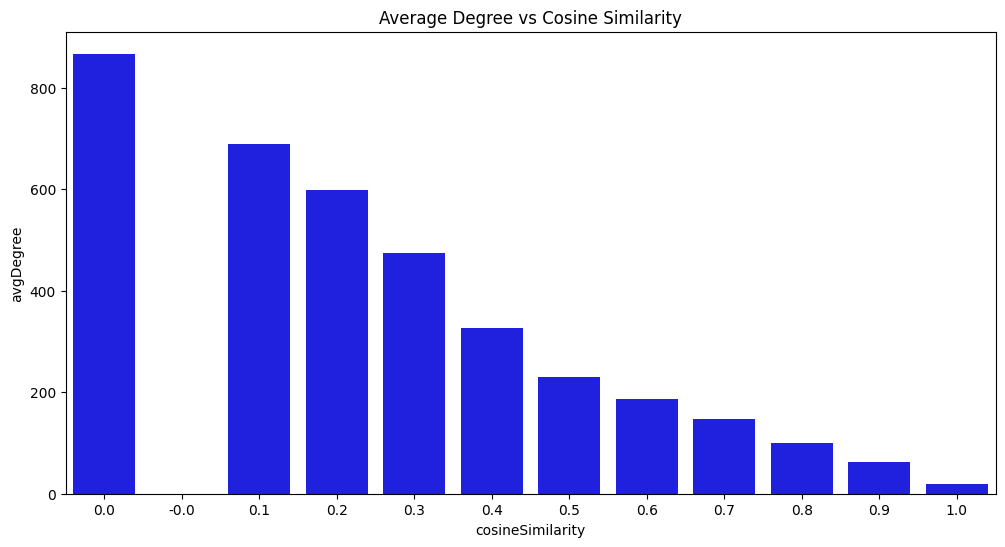

In [47]:
# Create a binned column for Cosine Similarity
df_analysis['cosineSimilarity'] = df_analysis['cosine'].round(1)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_analysis, x="cosineSimilarity", y="avgDegree", color="blue", errorbar=None)
plt.title("Average Degree vs Cosine Similarity")
plt.show()

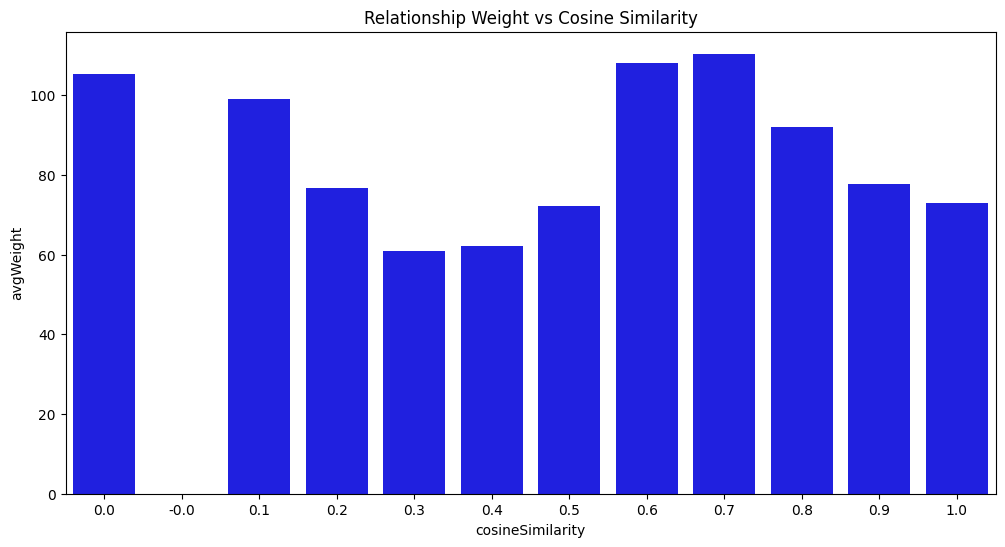

In [48]:
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_analysis, x="cosineSimilarity", y="weight", color="blue", errorbar=None)
plt.title("Relationship Weight vs Cosine Similarity")
plt.ylabel("avgWeight") # To match the lab label
plt.show()

In [51]:
# 1. Retrieve IDs, known languages, and embeddings
# We exclude nodes with no language (if any) or no embedding
ml_query = """
MATCH (s:Stream)
WHERE s.language IS NOT NULL AND s.embedding IS NOT NULL
RETURN s.id as id, s.language as language, s.embedding as embedding
"""
df = run_query(ml_query)

# 2. Prepare Feature Matrix (X)
# The 'embedding' column is a list of floats. We must split this into 64 separate columns.
X = pd.DataFrame(df['embedding'].tolist())

# 3. Prepare Target Vector (y)
# We convert string labels ('en', 'fr') into integers (0, 1)
y, class_names = pd.factorize(df['language'])

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")
print(f"Classes found: {class_names}")

X Shape: (3721, 128)
y Shape: (3721,)
Classes found: Index(['en', 'fr', 'ko', 'ru', 'es', 'de', 'zh-tw', 'tr', 'pt-br', 'it'], dtype='object')


Classification Report:
              precision    recall  f1-score   support

          en       0.84      0.92      0.88       321
          fr       0.92      0.85      0.88        53
          ko       1.00      0.88      0.93        57
          ru       0.96      0.85      0.90        52
          es       0.89      0.90      0.89        69
          de       0.92      0.82      0.86        66
       zh-tw       0.96      0.78      0.86        32
          tr       0.86      0.90      0.88        20
       pt-br       0.91      0.89      0.90        47
          it       0.96      0.86      0.91        28

    accuracy                           0.88       745
   macro avg       0.92      0.86      0.89       745
weighted avg       0.89      0.88      0.88       745



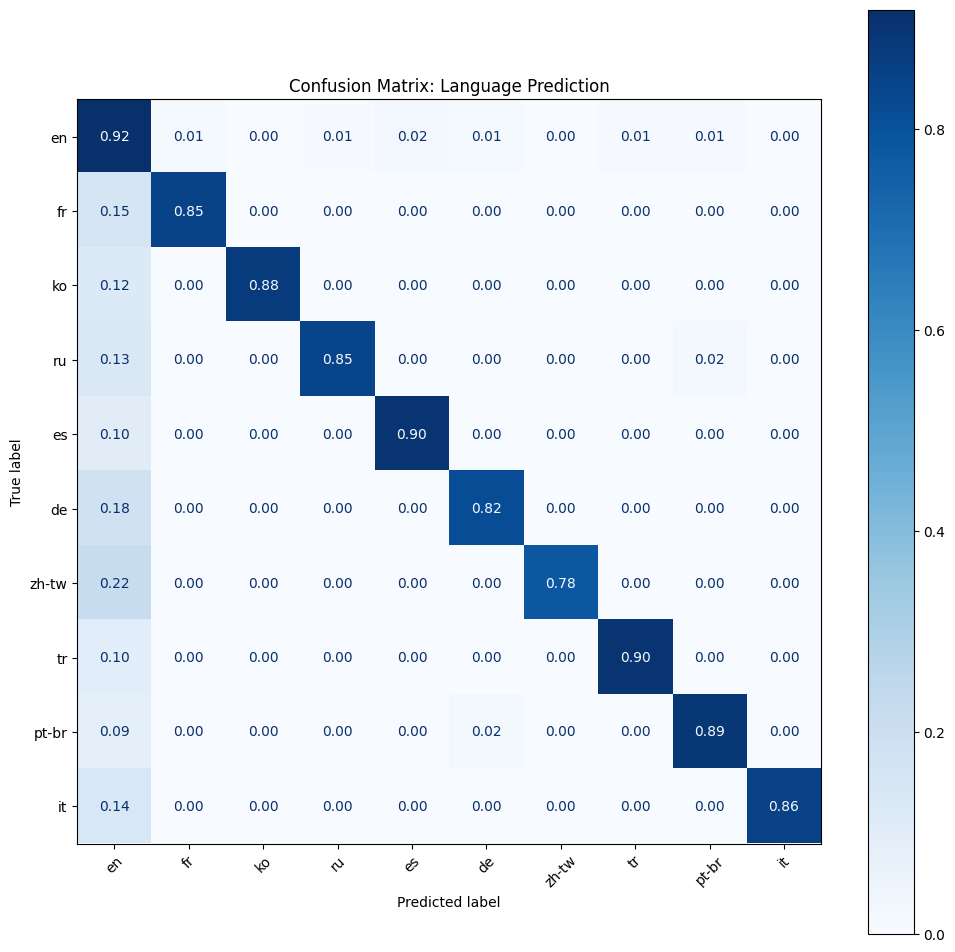

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Split Data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Initialise and Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 3. Predict on Test Set
y_pred = clf.predict(X_test)

# 4. Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# 5. Visualise Confusion Matrix
fig, ax = plt.subplots(figsize=(12, 12))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', values_format='.2f')
plt.xticks(rotation=45)
plt.title("Confusion Matrix: Language Prediction")
plt.show()